In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def plot_images(img1, img2, title1, title2, colormap1, colormap2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(img1, cmap=colormap1)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=colormap2)
    ax2.set_title(title2, fontsize=30)
    ax1.axis('off');
    ax2.axis('off');
    f.savefig("output_images/" + title2.replace(" ",""), bbox_inches='tight', transparent=True)

In [3]:
def camera_calibration():

    nx = 9
    ny = 6
    cal_images = glob.glob('camera_cal/calibration*.jpg')

    obj_pts = np.zeros((nx*ny, 3), np.float32)
    obj_pts[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    cal_obj_pts = []
    cal_img_pts = []

    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            cal_obj_pts.append(obj_pts)
            cal_img_pts.append(corners)
        
    ret, M, dist, rvecs, tvecs = cv2.calibrateCamera(cal_obj_pts, cal_img_pts, gray.shape[::-1], None, None)
    return M, dist

M_cal, dist_cal = camera_calibration()
    
def undistort(img):
    
    return cv2.undistort(img, M_cal, dist_cal, None, M_cal)

In [4]:
print(M_cal, dist_cal)

[[  1.15158804e+03   0.00000000e+00   6.66167057e+02]
 [  0.00000000e+00   1.14506859e+03   3.86440204e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] [[ -2.35510339e-01  -7.90388401e-02  -1.28492203e-03   8.25970403e-05
    7.22743173e-02]]


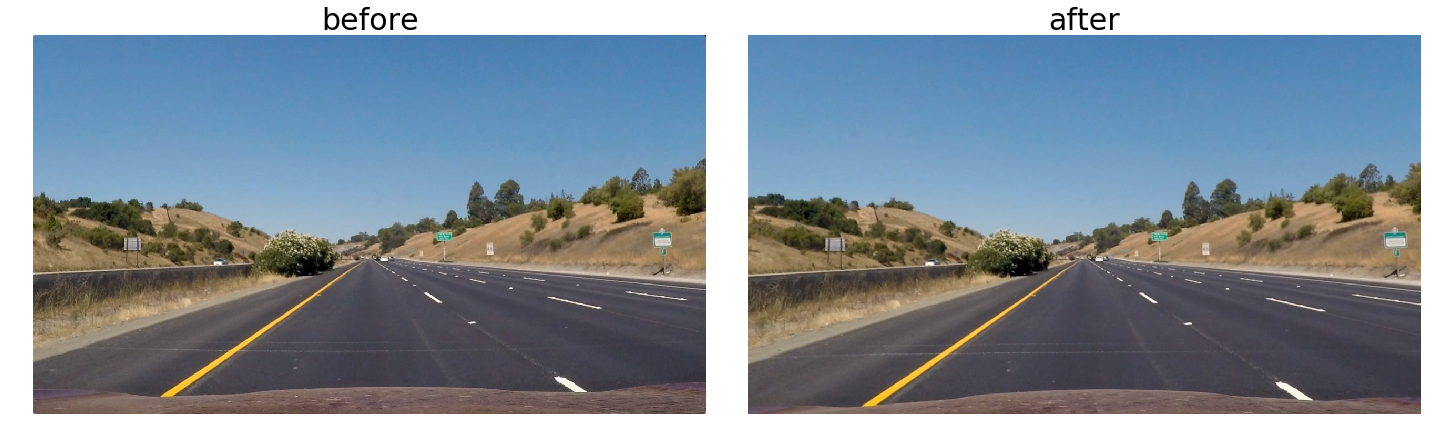

In [5]:
images = glob.glob('test_images/*.jpg')

img_0 = mpimg.imread(images[0])

img_1 = undistort(img_0)

plot_images(img_0, img_1, 'before', "after", 'gray', 'gray')

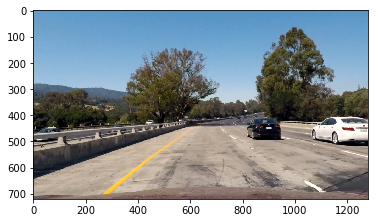

In [6]:
img = mpimg.imread(images[2])

img = undistort(img)
plt.imshow(img)

In [7]:
#Gradient Threshold
def r_thresh(img, thresh_min=0, thresh_max=100 ):
    r = img[:, :, 0]
    binary = np.zeros_like(r)
    binary[(r > thresh_min) & (r <= thresh_max)] = 1
    return binary 

def s_thresh(img, thresh_min=0, thresh_max=100 ):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    binary = np.zeros_like(s)
    binary[(s > thresh_min) & (s <= thresh_max)] = 1
    return binary 

def l_thresh(img, thresh_min=0, thresh_max=100 ):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l = hls[:, :, 1]
    binary = np.zeros_like(l)
    binary[(l > thresh_min) & (l <= thresh_max)] = 1
    return binary 

def h_thresh(img, thresh_min=0, thresh_max=100 ):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    binary = np.zeros_like(h)
    binary[(h > thresh_min) & (h <= thresh_max)] = 1
    return binary 

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combine_rs(img):
    s_thresh_ = s_thresh(img, thresh_min = 120, thresh_max = 255)
    r_thresh_ = r_thresh(img, thresh_min=140, thresh_max=255)
    pass
    
    


def combine_img_normal(img):
    
    s_thresh_ = s_thresh(img, thresh_min = 150, thresh_max = 255)
    r_thresh_ = r_thresh(img, thresh_min=170, thresh_max=255)
    
    combined = np.zeros_like(s_thresh_)
    
    combined[((s_thresh_==1)|(r_thresh_==1))] = 1
    
    h_thresh_ = h_thresh(img, thresh_min = 120, thresh_max = 255)
    
    combined[((h_thresh_== 1))] =0
    
    return combined



def reduce_car_head(img):
    h_thresh_ = h_thresh(img, thresh_min = 100, thresh_max = 255)
    l_thresh_ = l_thresh(img, thresh_min = 180, thresh_max = 255)
    
    combined = np.zeros_like(s_thresh_)
    combined[((s_thresh_==1)&(l_thresh_==1))] = 1
    
    return combined


def test_combine_img_normal(img):
    warped, M, Minv  = warp(img)
    temp = 0
    shape = warped.shape
    for i in range(500, 700, 1):
        for j in range(shape[1]):
            if warped[i][j] ==1:
                temp += 1
    return temp

    
def combine_img_with_xy(img):
    x_thresh_ = abs_sobel_thresh(img, orient='x', thresh_min=3, thresh_max=40)
    y_thresh_ = abs_sobel_thresh(img, orient='y', thresh_min=3, thresh_max=30)
    
    combined = np.zeros_like(x_thresh_)
    
    combined[((x_thresh_ == 1)&( y_thresh_ ==1))] =1
    
    h_thresh_ = h_thresh(img, thresh_min = 110, thresh_max = 255)

    combined[((h_thresh_== 1))] =0
    
    return combined

def combine_img_with_xy_2nd(img):
    r_thresh_ = r_thresh(img, thresh_min = 120, thresh_max = 255)
    combined = np.zeros_like(r_thresh_)
    
    combined[(r_thresh_ ==1)] =1
    combined[(dir_thresh(img, sobel_kernel=3, thresh=(0.8, 1.6))==1)] = 0
    
    h_thresh_ = h_thresh(img, thresh_min = 110, thresh_max = 255)

    combined[((h_thresh_== 1))] =0
    
    return combined

def reduce_light_hth(img):
    s_thresh_ = s_thresh(img, thresh_min = 150, thresh_max = 255)
    r_thresh_ = r_thresh(img, thresh_min=230, thresh_max=255)
    
    combined = np.zeros_like(s_thresh_)
    
    combined[(s_thresh_==1)|(r_thresh_==1)] = 1
    
    h_thresh_ = h_thresh(img, thresh_min = 100, thresh_max = 255)
    
    combined[(h_thresh_== 1)] =0
    
    return combined

def reduce_light_lth(img):
    s_thresh_ = s_thresh(img, thresh_min = 150, thresh_max = 255)
    r_thresh_ = r_thresh(img, thresh_min=200, thresh_max=255)
    
    combined = np.zeros_like(s_thresh_)
    
    combined[(s_thresh_==1)|(r_thresh_==1)] = 1
    
    h_thresh_ = h_thresh(img, thresh_min = 100, thresh_max = 255)
    combined[(h_thresh_== 1)] =0
    return combined

def combine_img(img):
    normal = combine_img_normal(img)
    if test_combine_img_normal(normal) < 800:
        if test_combine_img_normal(combine_img_with_xy(img)) > 4000:
            return combine_img_with_xy_2nd(img)
        else:
            return combine_img_with_xy(img)
        
    if test_combine_img_normal(normal) > 4000:
        if test_combine_img_normal(reduce_light_hth(img))> 1200:
            return reduce_light_hth(img)
        else:
            return reduce_light_lth(img)
        
    else:
        return normal
    


In [8]:
def find_corners():
    
    straight_line = r_thresh(undistort(mpimg.imread(images[0])), thresh_min=150, thresh_max=255)
    left_upper=[]
    upper = 500
    lower = 690
    for i in range(500, 600, 1):
        if straight_line[upper][i]==1:
            left_upper.append(i)
    c_0 = (np.min(left_upper), upper)
    
    right_upper=[]
    for i in range(650, 780,1):
        if straight_line[upper][i]==1:
            right_upper.append(i)
    c_1 = (np.max(right_upper), upper)

    left_bottom=[]
    for i in range(100, 300,1):
        if straight_line[lower][i]==1:
            left_bottom.append(i)
    c_2 = (np.min(left_bottom), lower)    
    
    right_bottom=[]
    for i in range(900, 1200,1):
        if straight_line[lower][i]==1:
            right_bottom.append(i)
    c_3 = (np.max(right_bottom), lower)
    
    return c_0, c_1, c_2, c_3

In [9]:
def find_corners_2nd():
    
    straight_line = r_thresh(undistort(mpimg.imread(images[1])), thresh_min=150, thresh_max=255)
    left_upper=[]
    upper = 590
    lower = 680
    for i in range(200, 400, 1):
        if straight_line[upper][i]==1:
            left_upper.append(i)
    c_0 = (np.min(left_upper), upper)
    
    right_upper=[]
    for i in range(800, 1200,1):
        if straight_line[upper][i]==1:
            right_upper.append(i)
    c_1 = (np.max(right_upper), upper)

    left_bottom=[]
    for i in range(200, 400,1):
        if straight_line[lower][i]==1:
            left_bottom.append(i)
    c_2 = (np.min(left_bottom), lower)    
    
    right_bottom=[]
    for i in range(800, 1200,1):
        if straight_line[lower][i]==1:
            right_bottom.append(i)
    c_3 = (np.max(right_bottom), lower)
    
    return c_0, c_1, c_2, c_3

In [10]:
def warp(img):
    
    image_height, image_width= img.shape[0:2]
    # Source coordinates
    src = np.float32([find_corners()])
    
    # Destination coordinates
    dst = np.float32([
            [image_width * 0.2, image_height * 0.5],
            [image_width * 0.8, image_height * 0.5],
            [image_width * 0.2, image_height * 1],
            [image_width * 0.8, image_height * 1],
        ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (image_width, image_height))

    return warped, M, Minv

def warp_2nd(img):
    
    image_height, image_width= img.shape[0:2]
    # Source coordinates
    src = np.float32([find_corners_2nd()])
    
    # Destination coordinates
    dst = np.float32([
            [image_width * 0.2, image_height * 0.8],
            [image_width * 0.8, image_height * 0.8],
            [image_width * 0.2, image_height * 1],
            [image_width * 0.8, image_height * 1],
        ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (image_width, image_height))

    return warped, M, Minv

In [11]:
print(images)

['test_images\\straight_lines1.jpg', 'test_images\\straight_lines2.jpg', 'test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']


4455


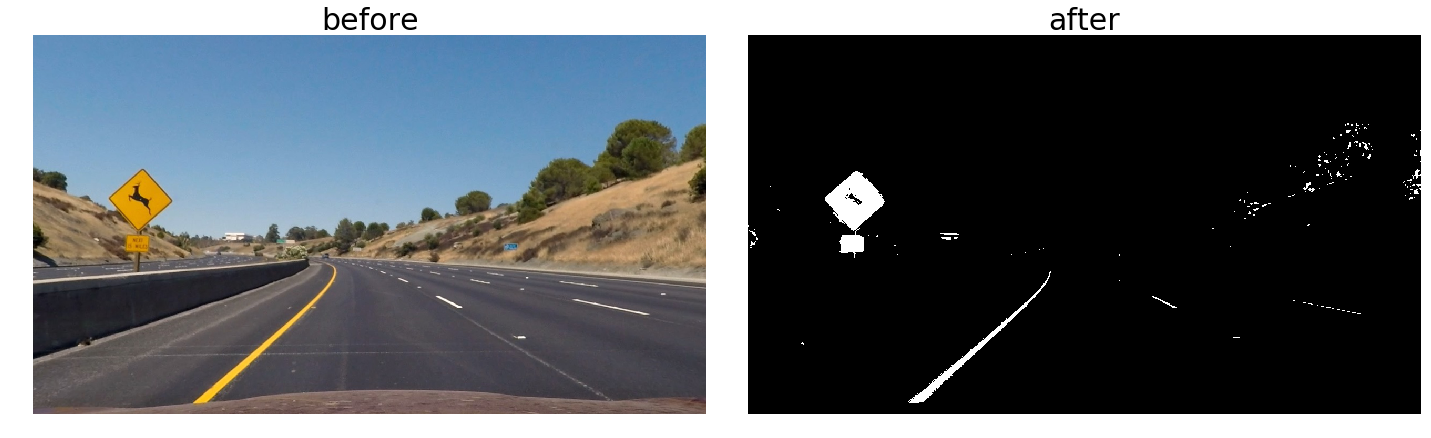

In [12]:
img = undistort(mpimg.imread('test_images\\test2.JPG'))

warped, M, Minv = warp((img))

print(test_combine_img_normal(combine_img(img)))

plot_images(img,  combine_img(img), 'before', "after", 'gray', 'gray')

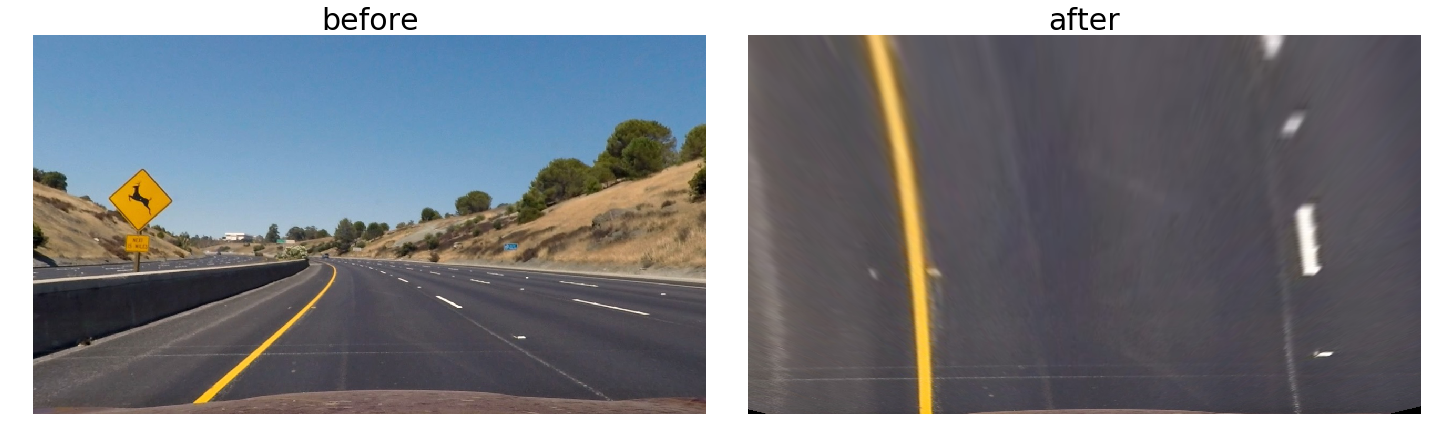

In [13]:
plot_images(img, warped, 'before', "after", 'gray', 'gray')

In [14]:
images

['test_images\\straight_lines1.jpg',
 'test_images\\straight_lines2.jpg',
 'test_images\\test1.jpg',
 'test_images\\test2.jpg',
 'test_images\\test3.jpg',
 'test_images\\test4.jpg',
 'test_images\\test5.jpg',
 'test_images\\test6.jpg']

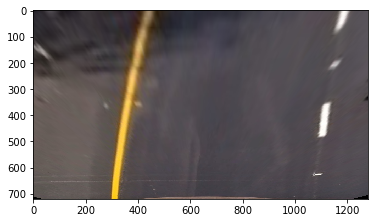

In [15]:
warped, M, Minv = warp(undistort(mpimg.imread(images[7])))
plt.imshow(warped)

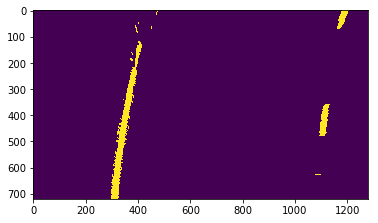

In [16]:
warped, M, Minv = warp(reduce_light_lth(undistort(mpimg.imread(images[7]))))
plt.imshow(warped)

((392, 590), (913, 590), (264, 680), (1058, 680))


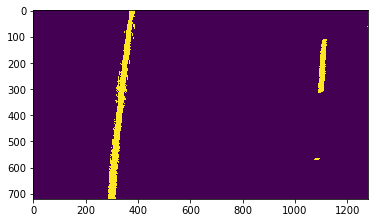

In [17]:
print(find_corners_2nd())

warped, M, Minv = warp_2nd(combine_img(undistort(mpimg.imread(images[7]))))

plt.imshow(warped)

In [18]:
def detect_lane_lines_initial(binary_warped):
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    last_fit = []
    
    # Choose between the two process for searching the lane
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #prevent sum of the lower half has zero inds
    
    if len(left_lane_inds) == 0 or len(right_lane_inds) == 0:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]*3//7:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        midpoint = np.int(histogram.shape[0]*4//5)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 10
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 10
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    
        
    try:
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:

        left_fit = [0,0,0]
        right_fit = [0,0,0]

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
      

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img, [right], False, (255,255,0), thickness=10)
    cv2.polylines(out_img, [left], False, (255,255,0), thickness=10)
    
    return [left_fit, right_fit], out_img
    

In [19]:
def detect_lane_lines(binary_warped, last_fit):

    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Choose between the two process for searching the lane

    left_fit = last_fit[0]
    right_fit = last_fit[1]

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    try:
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        left_fit = [0,0,0]
        right_fit = [0,0,0]

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    middle_fitx = 1/2.0*((left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])+(right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]))

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    middle_line_window1 = np.array([np.transpose(np.vstack([middle_fitx-margin, ploty]))])
    middle_line_window2 = np.array([np.flipud(np.transpose(np.vstack([middle_fitx+margin, ploty])))])
    middle_line_pts = np.hstack((middle_line_window1, middle_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([middle_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    
    return [left_fit, right_fit, middle_fitx], out_img, nonzeroy[left_lane_inds], nonzerox[left_lane_inds], nonzeroy[right_lane_inds], nonzerox[right_lane_inds]

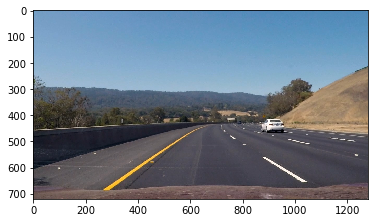

In [20]:
plt.imshow(mpimg.imread(images[4]))

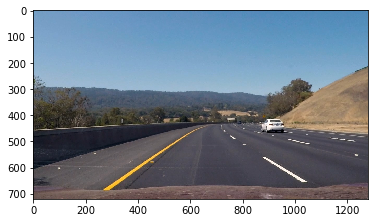

In [21]:
plt.imshow(mpimg.imread(images[4]))

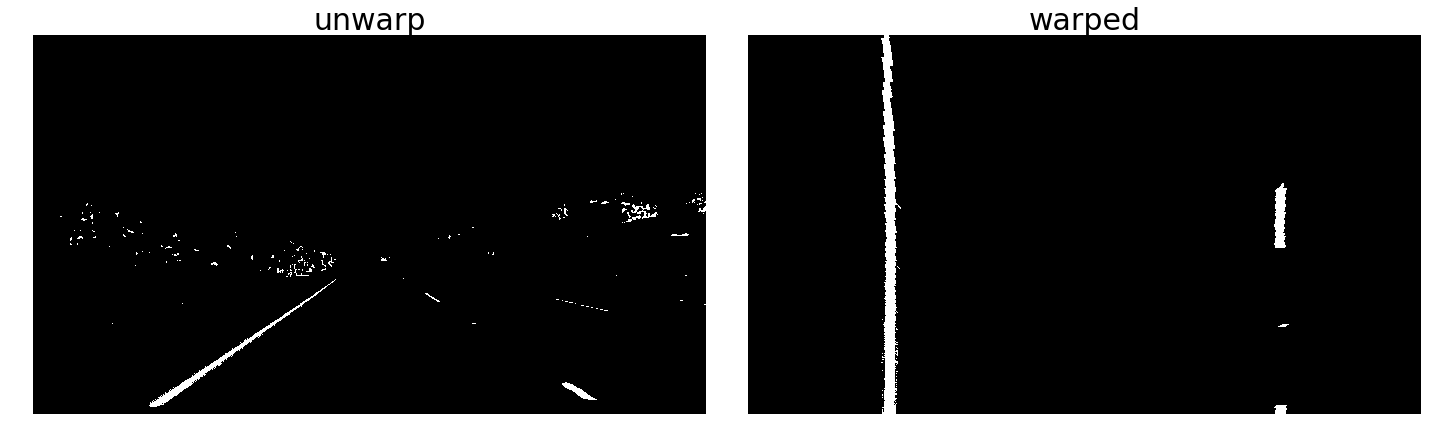

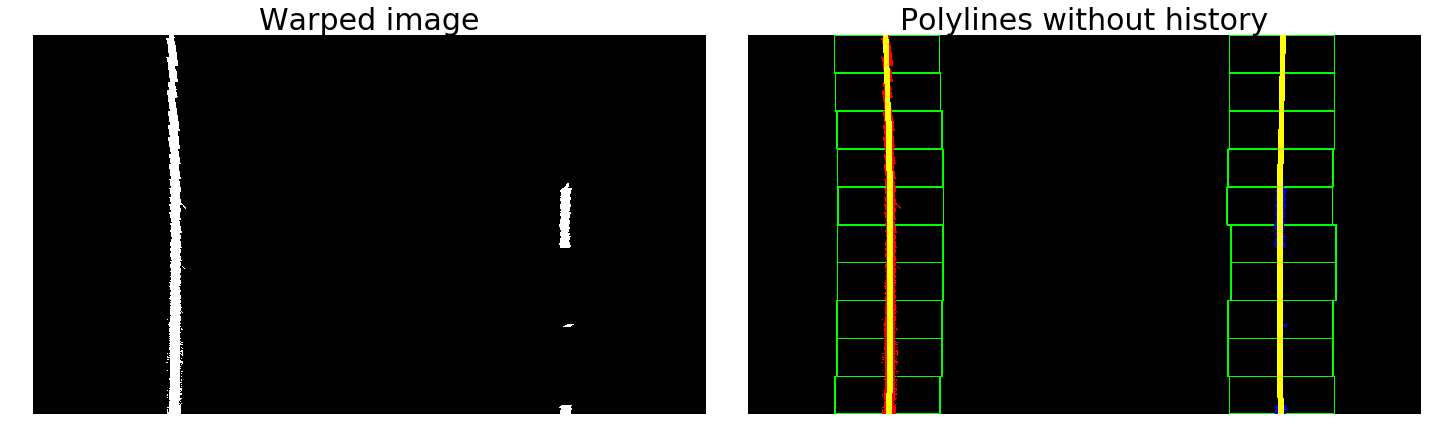

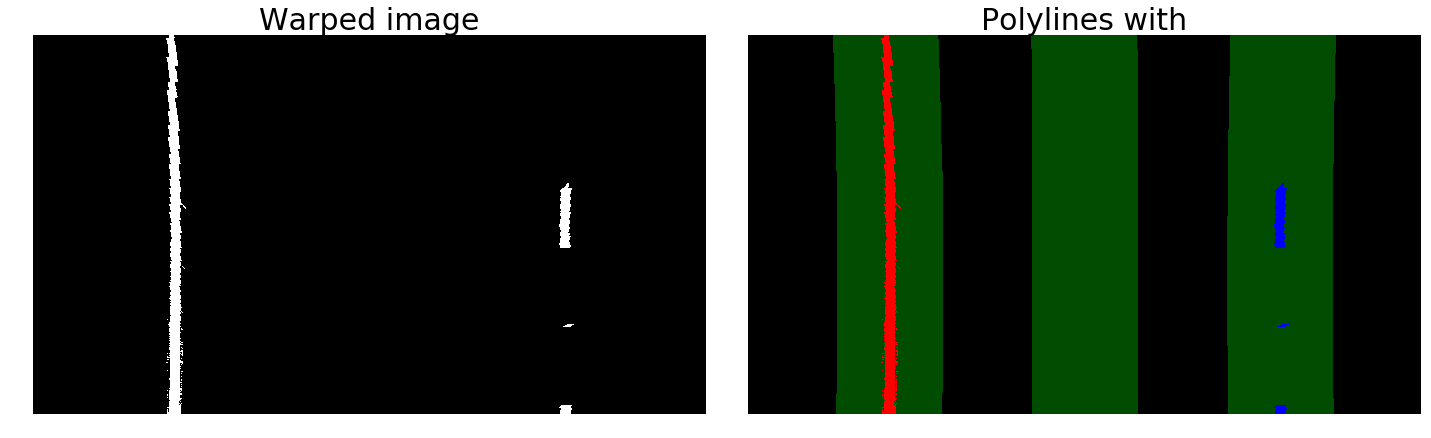

In [22]:
img = combine_img(undistort(mpimg.imread(images[0])))
warped, M, Minv = warp(img)
plot_images(img, warped, 'unwarp', "warped", 'gray', 'gray')


fit, out_img = detect_lane_lines_initial(warped)
plot_images(warped, out_img, 'Warped image', "Polylines without history", 'gray', 'jet')

fit, out_img, leftx, lefty, rightx, righty= detect_lane_lines(warped, fit) 
plot_images(warped, out_img, 'Warped image', "Polylines with", 'gray', 'jet')

In [23]:
def curvature(fit, leftx, lefty,rightx, righty):
    
    
    
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit = fit[0]
    right_fit = fit[1]
    middlex = fit[2]
    shape = [720, 1280]
    ploty = np.linspace(0, shape[0]-1, shape[0] )
    
    try:
        y_eval = max(np.concatenate((lefty, righty), axis=0))
         # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        middle_fit_cr = np.polyfit(ploty*ym_per_pix, middlex*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    
        middle_curverad = ((1 + (2*middle_fit_cr[0]*y_eval*ym_per_pix + middle_fit_cr[1])**2)**1.5) / np.absolute(2*middle_fit_cr[0]) 
        
        # Calculate offset
        offset = ( 640 - ((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]))/2)*xm_per_pix

    except:
        print(leftx, lefty, rightx, righty)
        y_eval = 720
    
        middle_curverad = 0
        left_curverad = 0
        right_curverad = 0
        offset = 0


    
    

    
  
    curvature = round(middle_curverad,2)
    
    if left_curverad > 5000:
        left_curverad = 5000
    if right_curverad > 5000:
        right_curverad = 5000
    if curvature > 5000:
        curvature = 5000
    
    
    # Build outputs
    center_offset = round(offset, 2)
    
    # If straight lines
    return [left_curverad, right_curverad, curvature], center_offset

curvature(fit, leftx, lefty, rightx, righty)

([1300.4421715454616, 4.3480569512049865, 5000], -0.0)

In [24]:
def curvature_check(fit):
    [left_curverad, right_curverad, _],  center_offset = curvature(fit, leftx, lefty,rightx, righty)
    print("curve_diff"+ str(abs(left_curverad - right_curverad)))
    if abs(left_curverad - right_curverad) < 5000:
        return True
    else:
        return False




def parallel(fit):
    left_fit = fit[0]
    right_fit = fit[1]
    lower = left_fit[0]*720**2+left_fit[1]*720 - (right_fit[0]*720**2+right_fit[1]*720)
    print("parallel"+str(abs(lower)))
    if  abs(lower) >350:
        return False
    else:
        return True
    
def good_distance(fit):
    left_fit = fit[0]
    right_fit = fit[1]
    dist = left_fit[0]*360**2+left_fit[1]*360 +left_fit[2] - (right_fit[0]*360**2+right_fit[1]*360+right_fit[2])
    print("distance"+str(dist))
    if 400<abs(dist)<800:
        return True
    else:
        return False

def sanity_check(fit):
    if parallel(fit) and good_distance(fit) and curvature_check(fit):
        return True
    else:
        return False

In [25]:
def curvature_check_2nd(fit):
    [left_curverad, right_curverad, _],  center_offset = curvature(fit, leftx, lefty,rightx, righty)
    print("curve_diff"+ str(abs(left_curverad - right_curverad)))
    if abs(left_curverad - right_curverad) < 1000:
        return True
    else:
        return False

def parallel_2nd(fit):
    left_fit = fit[0]
    right_fit = fit[1]
    lower = left_fit[0]*720**2+left_fit[1]*720 - (right_fit[0]*720**2+right_fit[1]*720)
    print("parallel"+str(abs(lower)))
    if  abs(lower) >100:
        return False
    else:
        return True
    
def good_distance_2nd(fit):
    left_fit = fit[0]
    right_fit = fit[1]
    dist = left_fit[0]*360**2+left_fit[1]*360 +left_fit[2] - (right_fit[0]*360**2+right_fit[1]*360+right_fit[2])
    print("distance"+str(dist))
    if 400<abs(dist)<800:
        return True
    else:
        return False

         
def sanity_check_2nd(fit):
    if parallel_2nd(fit) and good_distance_2nd(fit) and curvature_check_2nd(fit):
        return True
    else:
        return False

In [26]:
warped, M, Minv = warp(combine_img(undistort(mpimg.imread(images[4]))))
fit, out_img = detect_lane_lines_initial(warped)
fit, out_img, leftx, lefty, rightx, righty= detect_lane_lines(warped, fit)  
parallel(fit)
good_distance(fit)

print(curvature(fit, leftx, lefty,rightx, righty))

parallel9.80016959615
distance-743.862817302
([29.344129772928504, 93.75110929493934, 1132.79], -0.14999999999999999)


In [27]:
def draw_poly(distorted, Minv, fit, left_x, left_y, right_x, right_y):
    undistorted = undistort(distorted)
    # Get left and right polynomial equations
    left_fit = fit[0]
    right_fit = fit[1]
    
    # Draw the polynomial
    ploty = np.linspace(0, undistorted.shape[0], undistorted.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(undistorted[:,:,1]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    

    # Draw the lane onto the warped blank image
    sanity = sanity_check(fit)
    if sanity:
        
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
        # Color in left and right line pixels
    color_warp[left_x, left_y] = [255, 0, 0]
    color_warp[right_x, right_y] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.6, 0)
    
    return result, sanity

In [28]:
def force_draw_poly(distorted, Minv, fit, left_x, left_y, right_x, right_y):
    undistorted = undistort(distorted)
    # Get left and right polynomial equations
    left_fit = fit[0]
    right_fit = fit[1]
    
    # Draw the polynomial
    ploty = np.linspace(0, undistorted.shape[0], undistorted.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(undistorted[:,:,1]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    

    # Draw the lane onto the warped blank image
    sanity = sanity_check(fit)
        
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
        # Color in left and right line pixels
    color_warp[left_x, left_y] = [255, 0, 0]
    color_warp[right_x, right_y] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.6, 0)
    
    return result, sanity

In [29]:
def force_draw_poly_2nd(distorted, Minv, fit, left_x, left_y, right_x, right_y):
    undistorted = undistort(distorted)
    # Get left and right polynomial equations
    left_fit = fit[0]
    right_fit = fit[1]
    
    # Draw the polynomial
    ploty = np.linspace(0, undistorted.shape[0], undistorted.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(undistorted[:,:,1]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    

    # Draw the lane onto the warped blank image
    sanity = sanity_check_2nd(fit)
        
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
        # Color in left and right line pixels
    color_warp[left_x, left_y] = [255, 0, 0]
    color_warp[right_x, right_y] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.6, 0)
    
    return result, sanity

In [30]:
warped, M, Minv =  warp(combine_img(mpimg.imread(images[4])))

In [31]:
history = []

def img_frame(img):
    global history

    warped, M, Minv = warp(combine_img(undistort(img)))
    
    fit, out_img = detect_lane_lines_initial(warped)
    fit, out_img, leftx, lefty, rightx, righty= detect_lane_lines(warped, fit)  
    result, sanity = draw_poly(img, Minv, fit, leftx, lefty, rightx, righty)
    if sanity:
        history = [warped, M, Minv, fit, out_img, leftx, lefty, rightx, righty]
    # Introduce second check
    
    else:  
        warped, M, Minv = warp_2nd(combine_img(undistort(img)))
        fit, out_img = detect_lane_lines_initial(warped)
        fit, out_img, leftx, lefty, rightx, righty= detect_lane_lines(warped, fit)  
        result, sanity_0 = force_draw_poly_2nd(img, Minv, fit, leftx, lefty, rightx, righty)
        if sanity_0:
            history = [warped, M, Minv, fit, out_img, leftx, lefty, rightx, righty]
        
        else:
            [warped, M, Minv, fit, out_img, leftx, lefty, rightx, righty] = history
            result, sanity_1 = force_draw_poly(img, Minv, fit, leftx, lefty, rightx, righty)
        
    
        
    
    [_, _, curv],  center_offset = curvature(fit,leftx, lefty, rightx, righty )
    
    
    return result, curv, center_offset, sanity

In [32]:
def text_frame(img_in, curvature, offset, sanity):
    
    
    # Text formatting
    fontScale=1
    thickness=2
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
        
    # Curve and center offset text
    if sanity:
        if curvature < 5000:
            curvature = "Curvature: " + str(curvature) + ' m'
        else:
            curvature = "Curvature: Straight Line"
        center_offset = "Center offset: " + str(offset)  + ' m'
    else: 
        curvature = "Curvature: -"
        center_offset = "Center offset: - "
    
    cv2.putText(img_in, curvature, (40,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_in, center_offset, (40,80), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
    # Convert to BGR
    result = img_in
    
    return result

In [33]:
def combine_frame(img):
    result, curv, center_offset, sanity = img_frame(img)
    result = text_frame(result, curv, center_offset, sanity)
    
    return result

NameError: name 'NotebookApp' is not defined

0
parallel10.9900754752
distance-741.537917531
curve_diff64.406979522
1
parallel36.6243793985
distance-760.687670361
curve_diff64.406979522
2
parallel39.3647580133
distance-793.946448096
curve_diff64.406979522
3
parallel16.082729763
distance-747.298524672
curve_diff64.406979522
4
parallel9.80016959615
distance-743.862817302
curve_diff64.406979522
5
parallel69.1087651812
distance-779.19496804
curve_diff64.406979522
6
parallel37.3184858012
distance-825.551810741
parallel10.9444754002
distance-814.930967394
parallel69.1087651812
distance-779.19496804
curve_diff64.406979522
7
parallel27.9400758915
distance-760.08621309
curve_diff64.406979522


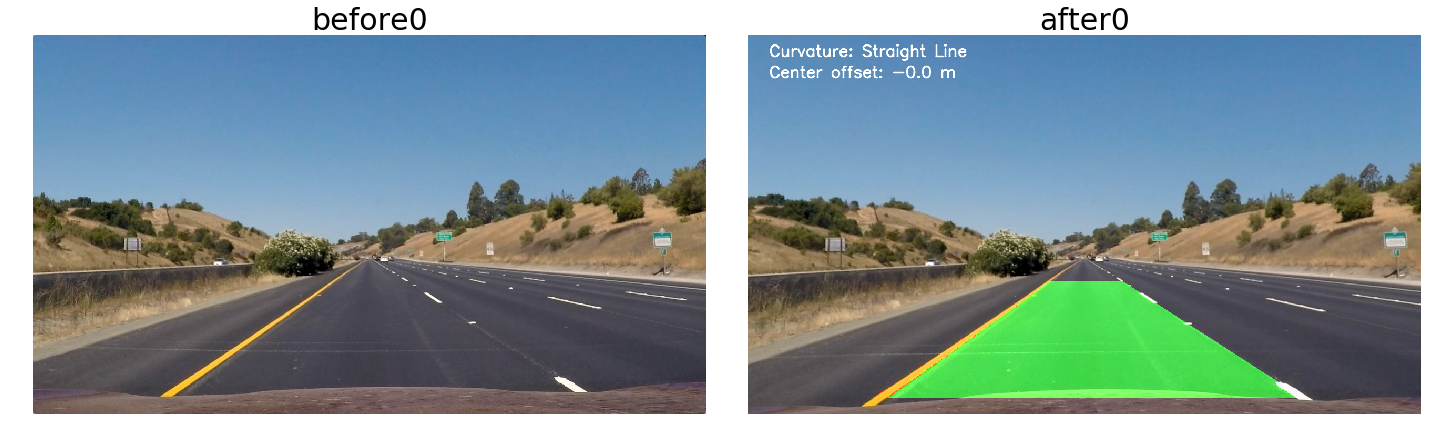

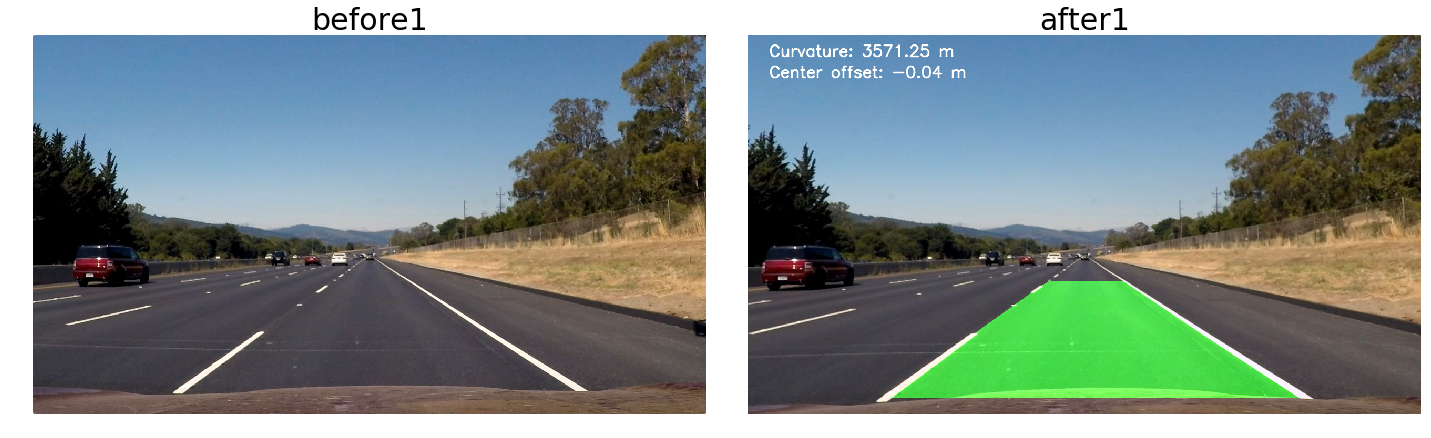

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


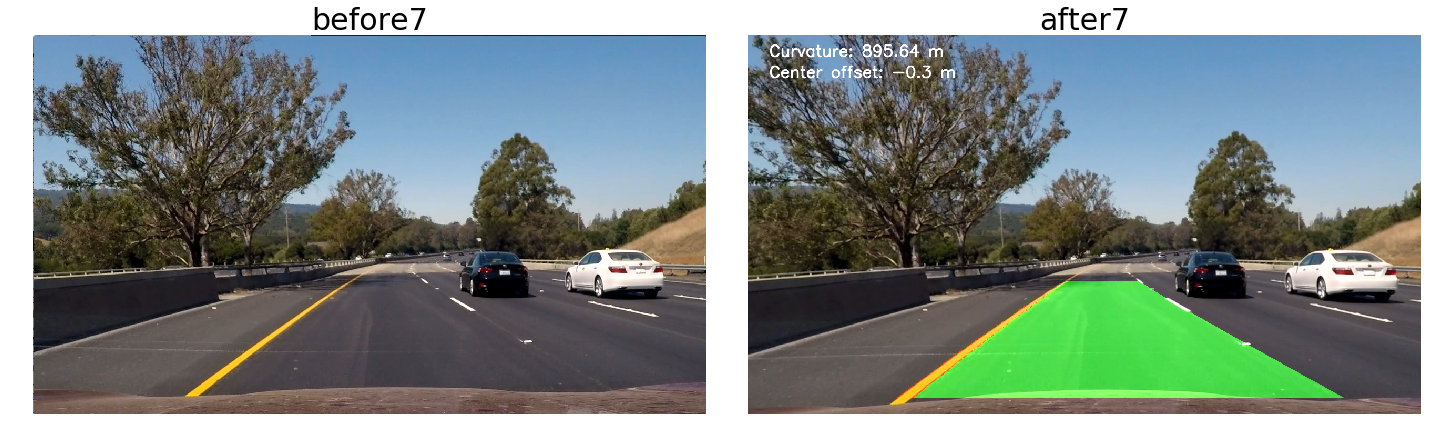

In [37]:
for num in range(len(images)):
    
    print(num)
    plot_images(mpimg.imread(images[num]), combine_frame(mpimg.imread(images[num])), 'before'+str(num), "after"+str(num), 'gray', 'gray')